In [1]:
import kagglehub

# Download latest version

path = kagglehub.dataset_download("zohaibmuaz/breast-cancer-histopathology")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/breast-cancer-histopathology


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import numpy as np
import pandas as pd
from albumentations.pytorch import ToTensorV2
import PIL.Image as Image

In [3]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(device)

cuda


In [4]:
from torchvision.datasets import ImageFolder
from PIL import UnidentifiedImageError

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except (UnidentifiedImageError, OSError) as e:
            # Skip the corrupted image
            print(f"Warning: Skipped corrupted image at index {index}")
            new_index = (index + 1) % len(self)
            return self.__getitem__(new_index)

In [5]:
os.listdir(path + "/Histopathological_MSI")

['benign', 'malignant']

In [6]:
data_dir = os.path.join(path,"Histopathological_MSI")
data_dir

'/kaggle/input/breast-cancer-histopathology/Histopathological_MSI'

In [7]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img


In [8]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ]
)

In [9]:
dataset = SafeImageFolder(data_dir,transform=transform)

In [10]:
train_dataset , test_dataset = random_split(dataset, [0.8,0.2])

In [11]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [12]:
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Image batch shape: torch.Size([32, 3, 128, 128])
Label batch shape: torch.Size([32])


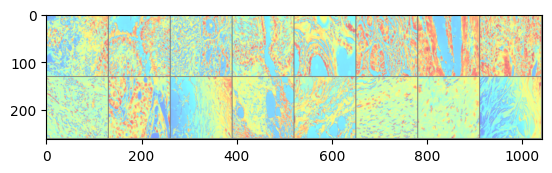

malignant benign benign benign benign malignant malignant malignant benign malignant


In [13]:
# prompt: visulaize 10 imags from each category

import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:16]))

# Print labels
print(' '.join('%5s' % dataset.classes[labels[j]] for j in range(10)))

In [19]:
model = nn.Sequential(
    nn.Conv2d(3,32,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32,64,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64,128,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(128 * 16 * 16, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128,2)
)
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=32768, out_features=128, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=128, out_features=2, bias=True)
)

In [20]:
optimizer = optim.Adam(model.parameters(),lr=1e-4)
loss = torch.nn.CrossEntropyLoss()

In [21]:
from training import train, predict, Accuracy

In [22]:
train(model,optimizer,loss,train_loader,test_loader,epochs = 10,device=device)

Model evaluation before start of training...


Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]



Starting epoch 1/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.6289
Training accuracy: 62.1094%
Validation loss: 0.6245
Validation accuracy: 66.0156%


Starting epoch 2/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.5765
Training accuracy: 64.1602%
Validation loss: 0.5869
Validation accuracy: 64.4531%


Starting epoch 3/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.5596
Training accuracy: 65.8203%
Validation loss: 0.5429
Validation accuracy: 67.9688%


Starting epoch 4/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.5646
Training accuracy: 65.8203%
Validation loss: 0.5897
Validation accuracy: 64.4531%


Starting epoch 5/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.5321
Training accuracy: 68.8477%
Validation loss: 0.5417
Validation accuracy: 69.1406%


Starting epoch 6/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.5175
Training accuracy: 71.4844%
Validation loss: 0.5339
Validation accuracy: 69.9219%


Starting epoch 7/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.5271
Training accuracy: 68.7500%
Validation loss: 0.5746
Validation accuracy: 69.1406%


Starting epoch 8/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.4917
Training accuracy: 72.7539%
Validation loss: 0.5048
Validation accuracy: 69.9219%


Starting epoch 9/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.5571
Training accuracy: 66.5039%
Validation loss: 0.6430
Validation accuracy: 60.5469%


Starting epoch 10/10


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.4729
Training accuracy: 75.0977%
Validation loss: 0.5066
Validation accuracy: 71.8750%


([0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001,
  0.0001],
 [0.6770372907049023,
  0.6289299266645685,
  0.5765351829468273,
  0.5595599110238254,
  0.5646076887496747,
  0.5320839993655682,
  0.5174785879207775,
  0.5270519322075415,
  0.49168117105728015,
  0.5571224458690267,
  0.4728772639646195],
 [0.6847433543298393,
  0.6245169427711517,
  0.586886833421886,
  0.5428526166360825,
  0.5897233497817069,
  0.5416847411543131,
  0.5339233810082078,
  0.5746237025596201,
  0.5047582723200321,
  0.6430402863770723,
  0.5065955689642578],
 [0.49609375,
  0.62109375,
  0.6416015625,
  0.658203125,
  0.658203125,
  0.6884765625,
  0.71484375,
  0.6875,
  0.7275390625,
  0.6650390625,
  0.7509765625],
 [0.44921875,
  0.66015625,
  0.64453125,
  0.6796875,
  0.64453125,
  0.69140625,
  0.69921875,
  0.69140625,
  0.69921875,
  0.60546875,
  0.71875],
 10)

In [23]:
probabilities_val = predict(model.to(device),test_loader,device)
predictions_val = torch.argmax(probabilities_val,dim=1)

Predicting:   0%|          | 0/8 [00:00<?, ?it/s]

In [24]:
Accuracy(model,test_loader,device)

✅ Accuracy on validation data: 0.7390


0.7389558232931727

In [27]:
def predict_and_visualize(model, image_path, device, transform, classes):
    # Load the image
    img = Image.open(image_path)

    # Apply the transformations (resize, ToTensor, normalize)
    img_transformed = transform(img)

    # Add batch dimension (model expects a batch)
    img_transformed = img_transformed.unsqueeze(0)
    img_transformed = img_transformed.to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(img_transformed)
        _, predicted_class = torch.max(output, 1)

    # Visualize the image and predicted label
    plt.imshow(img)
    plt.title(f"Predicted: {classes[predicted_class.item()]}", fontsize=14)
    plt.axis('off')  # Hide axis for a cleaner display
    plt.show()

    # Print the predicted label in the console
    print(f"Predicted: {classes[predicted_class.item()]}")

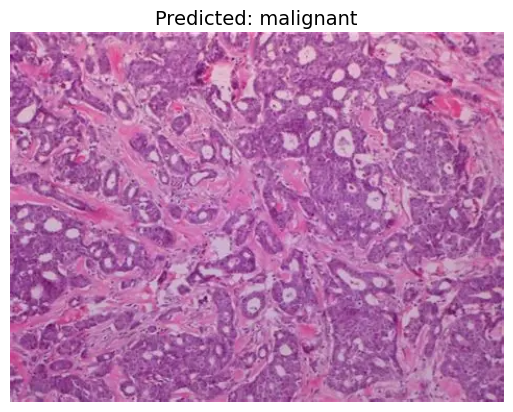

Predicted: malignant


In [28]:
# Example usage
image_path = "/content/OIP.jpg"  # Path to your image
predict_and_visualize(model, image_path, device, transform, dataset.classes)

# Now, Same training with VGG16 PRETRAINED MODEL

In [47]:
from torchvision import models
import torch.nn as nn

# Load pre-trained VGG16
vgg16 = models.vgg16(pretrained=True)

# Freeze all convolutional layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Replace the last layer of the classifier only
vgg16.classifier[6] = nn.Linear(4096, 2)  # 2 classes: benign, malignant
vgg16.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
optimizer = torch.optim.Adam(vgg16.classifier[6].parameters(), lr=1e-3)


In [51]:
train(vgg16,optimizer,loss,train_loader,test_loader,epochs = 12,device=device)

Model evaluation before start of training...


Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]



Starting epoch 1/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1
Training loss: 0.5158
Training accuracy: 72.6562%
Validation loss: 0.4991
Validation accuracy: 72.6562%


Starting epoch 2/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2
Training loss: 0.4544
Training accuracy: 75.5859%
Validation loss: 0.4766
Validation accuracy: 76.5625%


Starting epoch 3/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3
Training loss: 0.4411
Training accuracy: 75.7812%
Validation loss: 0.4792
Validation accuracy: 74.2188%


Starting epoch 4/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4
Training loss: 0.4338
Training accuracy: 76.2695%
Validation loss: 0.4589
Validation accuracy: 75.7812%


Starting epoch 5/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5
Training loss: 0.4551
Training accuracy: 76.1719%
Validation loss: 0.4700
Validation accuracy: 72.2656%


Starting epoch 6/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6
Training loss: 0.4187
Training accuracy: 76.7578%
Validation loss: 0.4698
Validation accuracy: 71.8750%


Starting epoch 7/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7
Training loss: 0.4177
Training accuracy: 77.9297%
Validation loss: 0.4498
Validation accuracy: 74.2188%


Starting epoch 8/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8
Training loss: 0.4472
Training accuracy: 77.3438%
Validation loss: 0.4639
Validation accuracy: 75.7812%


Starting epoch 9/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9
Training loss: 0.4179
Training accuracy: 79.2969%
Validation loss: 0.4440
Validation accuracy: 76.1719%


Starting epoch 10/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10
Training loss: 0.3994
Training accuracy: 79.3945%
Validation loss: 0.4397
Validation accuracy: 75.7812%


Starting epoch 11/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11
Training loss: 0.4030
Training accuracy: 79.2969%
Validation loss: 0.4462
Validation accuracy: 76.5625%


Starting epoch 12/12


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/32 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12
Training loss: 0.4264
Training accuracy: 78.8086%
Validation loss: 0.4625
Validation accuracy: 75.7812%


([0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001],
 [0.4802233825903386,
  0.5158159126294777,
  0.4543557525612414,
  0.44107673061080277,
  0.4338038634159602,
  0.45508840639377013,
  0.41868561995215714,
  0.4176999303163029,
  0.4472015029459726,
  0.41793482078355737,
  0.3994153490057215,
  0.4029527587699704,
  0.4263630303903483],
 [0.49090456520207226,
  0.49914206680841744,
  0.476621316280216,
  0.4791631423868239,
  0.4589235126040876,
  0.46995330252684653,
  0.46979978308081627,
  0.44975543837063015,
  0.4639203459955752,
  0.44403616653289646,
  0.4396902078296989,
  0.44620261108502746,
  0.462525773444213],
 [0.7294921875,
  0.7265625,
  0.755859375,
  0.7578125,
  0.7626953125,
  0.76171875,
  0.767578125,
  0.779296875,
  0.7734375,
  0.79296875,
  0.7939453125,
  0.79296875,
  0.7880859375],
 [0.73046875,
  0.7265625,
  0.765625,
  0.7421875,
  0.7578125,
  0.72265625,
  0.71875,
  0.7421875,
  0.7578125,
 

In [52]:
Accuracy(vgg16,test_loader,device)

✅ Accuracy on validation data: 0.7791


0.7791164658634538

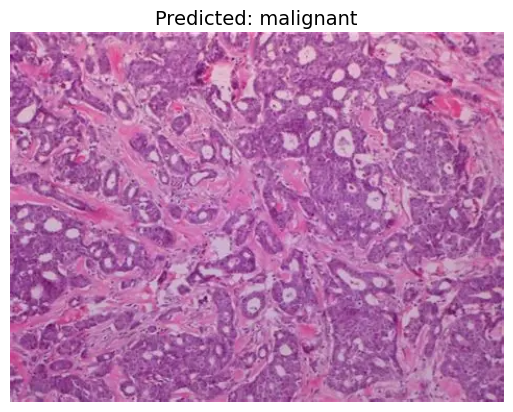

Predicted: malignant


In [53]:
# Example usage
image_path = "/content/OIP.jpg"  # Path to your image
predict_and_visualize(vgg16, image_path, device, transform, dataset.classes)